## Gibbs sampler
-----
(This needs iPython3 btw)
We're going to try out Gibbs sampling on the hypercube. The simplest possible case surely?

NOTE: this implementation calculates ratios of probabilities and doesn't do the work in log space. Working with logs instead would be necessary for a search space that was not-much-bigger that this, simply because the joint probabilities it uses would get very small (they're a big product of probabilities, so they're bound to get small for a large network). It's easy enough to change things to use logs instead (ends up with $p_1$ being sigmoid function of log ratio of the joint probs, ie. difference of two logs...), if you want or need to.

There are $N$ variables, and they're all binary, so there are $2^N$ states, which are the vertices of a hypercube in $N$ dimensions.

We'll simply specify some probability $P(\mathbf{x})$ for each pattern (= binary string) $\mathbf{x}$. (NOTE: to use a belief net instead of this, replace these "made up" probabilites with those derived from the appropriate product of Belief Net CPT entries).

Then we'll run heaps of Gibbs Sampler updates from some initial state, and count how often the sampler visits each state.

If we're right, these counts should come to match our target distribution: bingo!

In [19]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
np.set_printoptions(precision = 2, suppress = True)
import time
rng.seed(int(time.time())) # seed the random number generator
from collections import Counter

In [11]:
# make up an array with each row being one of the binary patterns. Do 'em all.
N = 3
# Oh dear: there are better ways to do this than simply reciting, but it's 3:55pm!
inpats = np.array([[0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]])
print (inpats)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


In [12]:
# Make up some probability distribution over all the inpats
targetProbs = rng.random(size=(len(inpats),1))
targetProbs = targetProbs / targetProbs.sum()
print (targetProbs)

[[ 0.23]
 [ 0.21]
 [ 0.02]
 [ 0.11]
 [ 0.18]
 [ 0.17]
 [ 0.07]
 [ 0.01]]


## Gibbs goes here

In [13]:
# create a dictionary of patterns to their probabilities
probs = {}
i = 0
for pat in inpats:
    probs[tuple(pat)] = targetProbs[i][0]
    i += 1
probs 

{(0, 0, 0): 0.23254471052522624,
 (0, 0, 1): 0.20707328765714869,
 (0, 1, 0): 0.01954439099980438,
 (0, 1, 1): 0.11342810998083851,
 (1, 0, 0): 0.1775999011580138,
 (1, 0, 1): 0.17337768551479105,
 (1, 1, 0): 0.068417009133759588,
 (1, 1, 1): 0.0080149050304176659}

In [14]:
def gibbs_step(x, probs):
    """Perform one gibbs step, moving in one dimension"""
    
    # generate random dimension, j
    j = rng.randint(0,3)
    
    # ugh this isn't very pretty sorry!
    x_j_one = np.copy(x)
    x_j_one[j] = 1 # the x pattern where dim j is 1
    x_j_zero = np.copy(x)
    x_j_zero[j] = 0 # and x pattern where dim j is 0
    
    
    # grab the probabilies of x where j = 1 and 0 respectively
    p_j_one = probs[tuple(x_j_one)]
    p_j_not_one = probs[tuple(x_j_zero)]
    
    # Gibbs gives us the probability that it should turn x[j] to 1
    p_takes_one = p_j_one / (p_j_not_one + p_j_one)
    
    # bent coin flip
    if rng.random() <= p_takes_one:
        return x_j_one
    else:
        return x_j_zero
    
def gibbs_sampling(probs, epochs = 100, samples = 1000):
    """Perform gibbs sampling, epochs here is the number of gibbs steps to take between grabbing a sample, 
    we want it to explore the state space. Samples is the number of samples we will take. """
    
    # dictionary from sample to number of times it has occurred
    results = Counter()
    
    # we start from a random pattern
    x = rng.randint(0,2,(3))
    for samples in range(samples):
        for epoch in range(epochs):
            # do a gibbs step
            x = gibbs_step(x, probs)
        # grab a sample! and increment it's count
        results[tuple(x)] += 1
    return results

In [15]:
def normalise_counter(to_normalise,z):
    """Takes a Dictionary from Sample to count and normalises it, so we end up with a
    dictionary from sample to its approximated probability"""
    normalised_result = Counter()
    for key in to_normalise:
        normalised_result[key] += (to_normalise[key]/z)
    return normalised_result

def plot_dict(to_plot,series_two , title = "", size = None):
    """A messy helper function to plot the data"""
    keys = list(to_plot.keys())
    keys.sort()
    vals_one = []
    vals_two = []
    for key in keys:
        vals_one.append(to_plot[key])
        vals_two.append(series_two[key])
 
    if size is not None:
        plt.figure(figsize=(30,15))
    plt.title = title 
    width = 0.25
    plt.bar(np.array(list(range(len(vals_one)))) + width, vals_one,width=width,color = 'g',align= 'center')
    plt.bar(range(len(vals_two)),vals_two,width=width,color = 'b', align= 'center')
    plt.xticks(range(len(keys)), keys, rotation='vertical')
    plt.show()

## compare samples made by Gibbs with the target distribution

In [16]:
# do it, visually if possible.
num_samples = 1000
results = gibbs_sampling(probs, samples=num_samples)

In [17]:
normalised_result = normalise_counter(results, num_samples)

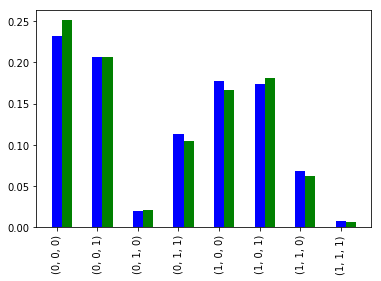

In [18]:
# plot a comparison of the normalised sample counts and the actual probabilities
plot_dict(normalised_result,probs)